# Face detection & recognition

Resources:
* Face detection using MTCNN: https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
* Simple face alignment (rotation & scaling): http://datahacker.rs/010-how-to-align-faces-with-opencv-in-python/
* Face recognition using VGGFace: https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/
* Cosine similarity: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [33]:
!pip3.8 install mtcnn==0.1.0 keras_vggface keras_applications sklearn

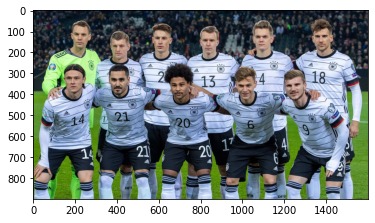

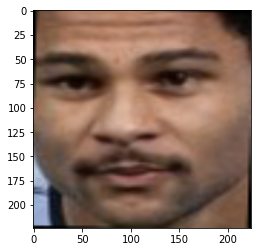

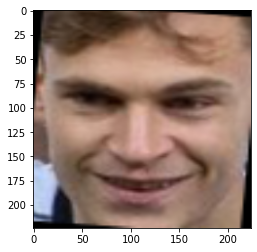

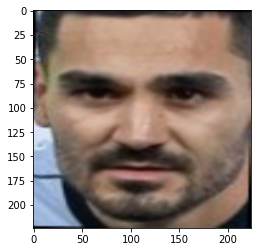

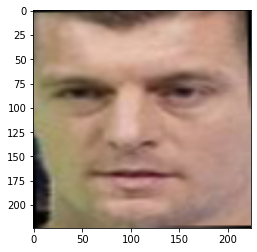

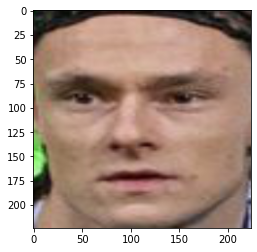

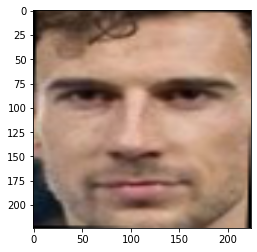

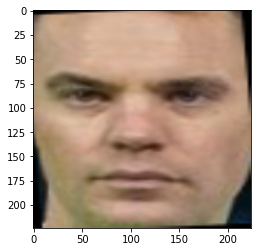

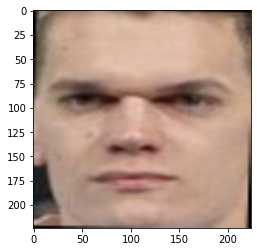

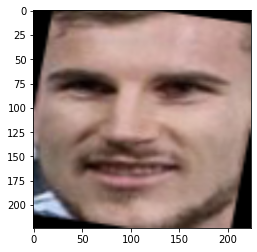

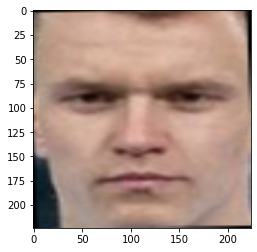

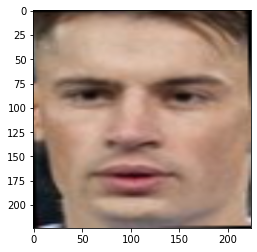

Detected faces:  11


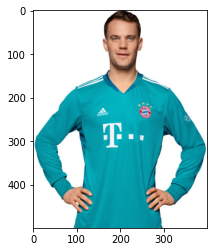

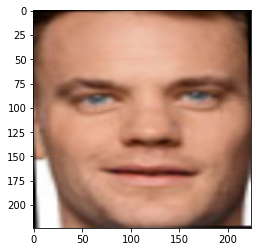

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='max')
detector = MTCNN()

FACE_DETECTION_CONFIDENCE_THRESHOLD = 0.8

# align face = orientate eyes 
def align_face(face_image, result):
    left_eye = result['keypoints']['left_eye']
    right_eye = result['keypoints']['right_eye']
    
    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    angle = np.arctan(delta_y / delta_x)
    angle = (angle * 180) / np.pi
    
    height, width, _ = face_image.shape
    
    M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1.0)
    return cv2.warpAffine(face_image, M, (width, height))

# extract & align face (rotation & scaling)
def extract_face(image, result, target_size=(224, 224), align = True):
    x, y, width, height = result['box']
    face_image = image[y:y + height, x:x + width]
    
    if align:
        face_image = align_face(face_image, result)
    
    face_image = cv2.resize(face_image, target_size)
    return face_image

# scale to [0..1]
def normalize_vector(vector):
    return (vector - np.min(vector)) / (np.max(vector) - np.min(vector))

def extract_faces_and_vectors(filename, display = True):
    image = plt.imread(filename)
    face_results = detector.detect_faces(image)
    
    plt.imshow(image)
    plt.show()
    
    faces_with_vectors = []
    
    for result in face_results:
        if result['confidence'] < FACE_DETECTION_CONFIDENCE_THRESHOLD:
            continue
        
        face_image = extract_face(image, result)
        
        if display:
            plt.imshow(face_image)
            plt.show()

        face_data = face_image.astype('float32')
        face_data = np.expand_dims(face_data, axis=0)
        face_data = utils.preprocess_input(face_data, version=2)
        face_vector = vgg_features.predict(face_data)[0]
        face_vector = normalize_vector(face_vector)
        
        faces_with_vectors.append((face_image, face_vector))
    return faces_with_vectors
    
faces_with_vectors = extract_faces_and_vectors('group.jpg')
print('Detected faces: ', len(faces_with_vectors))

face_with_vector = extract_faces_and_vectors('single.jpg')[0]

In [127]:
from sklearn.metrics.pairwise import cosine_similarity

def get_k_most_similar(faces_with_vectors, face_with_vector, k = 5):
    vectors = [vector for (_, vector) in faces_with_vectors]
    vector = [face_with_vector[1]]

    similarities = cosine_similarity(vector, vectors)[0]

    indexed_similarities = [(index, similarity) for (index, similarity) in enumerate(similarities)]
    indexed_similarities.sort(reverse=True, key=lambda index_with_similarity : index_with_similarity[1])
    
    return [(faces_with_vectors[index][0], faces_with_vectors[index][1], similarity) for (index, similarity) in indexed_similarities[0:k]]

Face to find:


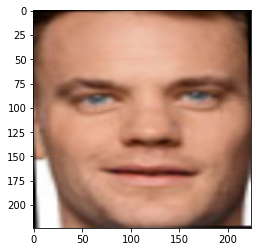

Most similar face:


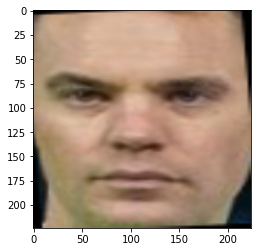

Similarity:  89.98


In [128]:
THRESHOLD = 0.80

most_similar = get_k_most_similar(faces_with_vectors, face_with_vector, 1)[0]
(face, vector, similarity) = most_similar

print('Face to find:')
plt.imshow(face_with_vector[0])
plt.show()
if similarity >= THRESHOLD:
    print('Most similar face:')
    plt.imshow(face)
    plt.show()
    print('Similarity: ', '%.2f' % round(similarity * 100, 2))
else:
    print('No face had a sufficiently high similarity score.')

## Ideas:
### Front door faces
* set up camera system
* take picture every ~5 sec
* detect faces: extract and vectorize
* send to backend
* on backend: configure known faces
  * person to several face images
  * compare taken image to known faces
  * mark if someone known is in front of the door (check against threshold)
  * mark that someone unknown in there
### Person tracking across several scenes
* entrance: take picture and get faces
* create entity for each face: customer
* when customers get in front of another camera (different location): update record for person - at new location
### Recognize your customer
* at entrance: check in via face
* greet customer utilizing the information stored

## Optimizations:
* face alignment, use landmarks to change orientation & rotation - https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/
* pivot table for face database: faster data retrieval - https://arxiv.org/pdf/1610.00574.pdf